<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN many-to-one

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [4]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    valid_loss = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Valid Loss {epoch_valid_loss:.3f}")

    history = {
        "loss": train_loss,
        "val_loss": valid_loss,
    }
    return history

In [5]:
# Generar datos sintéticos
X = list()
y = list()

# X será una lista de 1 a 45 agrupado de a 3 números consecutivos
# [ [1, 2, 3], [4, 5, 6], ....]
X = [ [x, x+1, x+2] for x in range(1, 46, 3)]

# "y" (target) se obtiene como la suma de cada grupo de 3 números de entrada
y = [sum(x) for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15], [16, 17, 18], [19, 20, 21], [22, 23, 24], [25, 26, 27], [28, 29, 30], [31, 32, 33], [34, 35, 36], [37, 38, 39], [40, 41, 42], [43, 44, 45]]
datos y: [6, 15, 24, 33, 42, 51, 60, 69, 78, 87, 96, 105, 114, 123, 132]


In [6]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), len(X[0]), 1)
print("datos X:", X)

datos X: [[[ 1]
  [ 2]
  [ 3]]

 [[ 4]
  [ 5]
  [ 6]]

 [[ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]]

 [[13]
  [14]
  [15]]

 [[16]
  [17]
  [18]]

 [[19]
  [20]
  [21]]

 [[22]
  [23]
  [24]]

 [[25]
  [26]
  [27]]

 [[28]
  [29]
  [30]]

 [[31]
  [32]
  [33]]

 [[34]
  [35]
  [36]]

 [[37]
  [38]
  [39]]

 [[40]
  [41]
  [42]]

 [[43]
  [44]
  [45]]]


In [7]:
# (batch size, seq_len, input_size)
X.shape

(15, 3, 1)

In [8]:
y = np.asanyarray(y)
y.shape

(15,)

In [9]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1:]
seq_length = input_dim[0]
input_size = input_dim[1]
print("Input dim", input_dim)
print("seq_length:", seq_length)
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim torch.Size([3, 1])
seq_length: 3
input_size: 1
Output dim 1


In [10]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

# Cuando trabajmos con una serie temporal no mezclamos (shuffle) los datos
train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 12
Tamaño del conjunto de validacion: 3


### 2 - Entrenar el modelo

In [11]:
from torch_helpers import CustomLSTM

class Model1(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()
        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model1 = Model1(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = nn.MSELoss()  # mean squared error

summary(model1, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─CustomLSTM: 1-1                        [1, 3, 64]                16,896
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Sigmoid: 2-4                      [1, 64]                   --
│    └─ReLU: 2-5                         [1, 64]                   --
│    └─Sigmoid: 2-6                      [1, 64]                   --
│    └─Sigmoid: 2-7                      [1, 64]                   --
│    └─ReLU: 2-8                         [1, 64]                   --
│    └─Sigmoid: 2-9                      [1, 64]                   --
│    └─ReLU: 2-10                        [1, 64]                   --
│    └─Sigmoid: 2-11                     [1, 64]                   --
│    └─Sigm

In [12]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 3985.212 - Valid Loss 14189.081
Epoch: 2/500 - Train loss 3820.677 - Valid Loss 13402.776
Epoch: 3/500 - Train loss 3619.945 - Valid Loss 12313.651
Epoch: 4/500 - Train loss 3336.783 - Valid Loss 10654.391
Epoch: 5/500 - Train loss 2916.646 - Valid Loss 8250.131
Epoch: 6/500 - Train loss 2320.469 - Valid Loss 5615.265
Epoch: 7/500 - Train loss 1611.336 - Valid Loss 2937.641
Epoch: 8/500 - Train loss 882.433 - Valid Loss 677.906
Epoch: 9/500 - Train loss 251.921 - Valid Loss 121.080
Epoch: 10/500 - Train loss 31.194 - Valid Loss 2322.760
Epoch: 11/500 - Train loss 504.735 - Valid Loss 3205.851
Epoch: 12/500 - Train loss 724.993 - Valid Loss 2230.922
Epoch: 13/500 - Train loss 509.816 - Valid Loss 931.862
Epoch: 14/500 - Train loss 211.117 - Valid Loss 160.523
Epoch: 15/500 - Train loss 36.715 - Valid Loss 10.998
Epoch: 16/500 - Train loss 14.530 - Valid Loss 244.790
Epoch: 17/500 - Train loss 84.339 - Valid Loss 551.605
Epoch: 18/500 - Train loss 168.096 - Vali

Epoch: 24/500 - Train loss 15.617 - Valid Loss 37.038
Epoch: 25/500 - Train loss 9.684 - Valid Loss 191.270
Epoch: 26/500 - Train loss 42.383 - Valid Loss 287.803
Epoch: 27/500 - Train loss 65.276 - Valid Loss 265.193
Epoch: 28/500 - Train loss 63.445 - Valid Loss 199.227
Epoch: 29/500 - Train loss 47.898 - Valid Loss 130.002
Epoch: 30/500 - Train loss 30.953 - Valid Loss 59.750
Epoch: 31/500 - Train loss 14.903 - Valid Loss 13.171
Epoch: 32/500 - Train loss 5.221 - Valid Loss 0.103
Epoch: 33/500 - Train loss 3.919 - Valid Loss 13.346
Epoch: 34/500 - Train loss 8.817 - Valid Loss 36.701
Epoch: 35/500 - Train loss 15.607 - Valid Loss 54.235
Epoch: 36/500 - Train loss 20.019 - Valid Loss 54.665
Epoch: 37/500 - Train loss 19.036 - Valid Loss 34.464
Epoch: 38/500 - Train loss 11.554 - Valid Loss 0.490
Epoch: 39/500 - Train loss 2.640 - Valid Loss 90.592
Epoch: 40/500 - Train loss 20.087 - Valid Loss 22.963
Epoch: 41/500 - Train loss 7.335 - Valid Loss 6.618
Epoch: 42/500 - Train loss 2.887

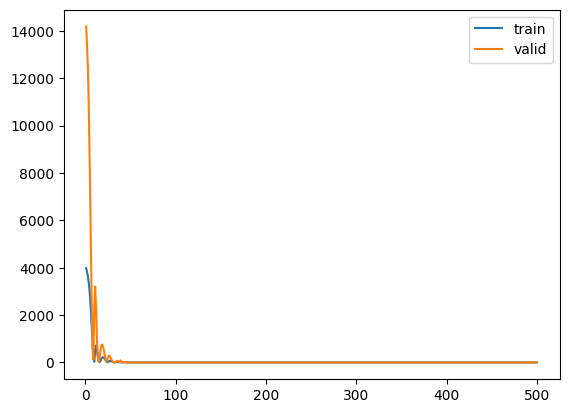

In [13]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='valid')
plt.show()

In [14]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model1(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model1_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 153
y_hat: tensor([[152.6315]], grad_fn=<AddmmBackward0>)
loss: 0.13580331206321716


### 3 - Bidirectional RNN (BRNN)

Como la implementación de "CustomLSTM" no soporta el flag de "bidirectional" que trae Pytorch, utilizaremos la layer por defecto de LSTM. Por eso notará que la cantidad de parámetros con bidireccional no es exactamente el doble (porque pytorch agrega otro bias a la ecuación tradicional).\
La única desventaja en este caso, al tratarse de una serie temporal no podremos utilizar la función de activación "relu" y por lo tanto el resultado alcanzado no será tan bueno como con la CustomLSTM.

In [15]:
from torch_helpers import CustomLSTM

# En esta oportunidad se utilizará Bidirectional, dentro se especifica
# que lo que se desea hacer bidireccional es una capa LSTM

# En el summary se puede observar que la cantidad de parámetros
# de nuestor nueva capa LSTM bidireccional es el doble que la anterior

class Model2(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(in_features=2*64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model2 = Model2(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
model2_criterion = nn.MSELoss()  # mean squared error

summary(model2, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1]                    --
├─LSTM: 1-1                              [1, 3, 128]               34,304
├─Linear: 1-2                            [1, 1]                    129
Total params: 34,433
Trainable params: 34,433
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.14
Estimated Total Size (MB): 0.14

In [16]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 4051.579 - Valid Loss 14986.512
Epoch: 2/500 - Train loss 3969.145 - Valid Loss 14815.323
Epoch: 3/500 - Train loss 3893.420 - Valid Loss 14646.310
Epoch: 4/500 - Train loss 3817.710 - Valid Loss 14465.633
Epoch: 5/500 - Train loss 3737.754 - Valid Loss 14269.555
Epoch: 6/500 - Train loss 3651.955 - Valid Loss 14056.142
Epoch: 7/500 - Train loss 3559.921 - Valid Loss 13824.684
Epoch: 8/500 - Train loss 3463.193 - Valid Loss 13580.624
Epoch: 9/500 - Train loss 3365.207 - Valid Loss 13339.075
Epoch: 10/500 - Train loss 3269.725 - Valid Loss 13112.950
Epoch: 11/500 - Train loss 3178.460 - Valid Loss 12901.239
Epoch: 12/500 - Train loss 3090.715 - Valid Loss 12696.786
Epoch: 13/500 - Train loss 3004.997 - Valid Loss 12494.028
Epoch: 14/500 - Train loss 2920.095 - Valid Loss 12288.687
Epoch: 15/500 - Train loss 2835.380 - Valid Loss 12077.595
Epoch: 16/500 - Train loss 2751.103 - Valid Loss 11861.583
Epoch: 17/500 - Train loss 2668.267 - Valid Loss 11645.458
Epoch:

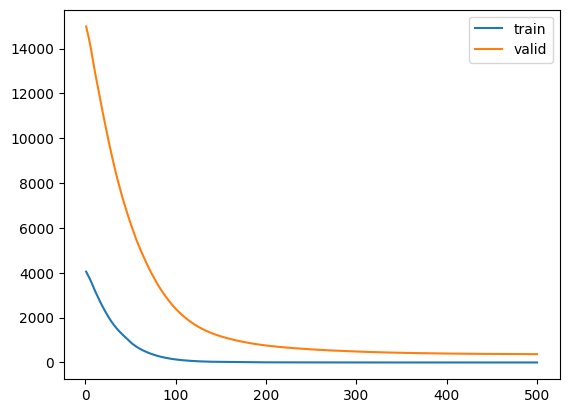

In [17]:
epoch_count = range(1, len(history2['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_loss'], label='valid')
plt.show()

In [18]:
# Ensayo
x_test = [50, 51, 52]
y_test = sum(x_test)
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model2(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model2_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: 153
y_hat: tensor([[105.1851]], grad_fn=<AddmmBackward0>)
loss: 2286.2685546875


### 4 - Conclusión
Implementar un modelo bidireccional basado en RNN (en este caso LSTM) es muy sensillo. En este ejemplo no se explotó su potencialidad pero queda como nota de como implementar una capa BRNN.